## Loading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv(r"BPD_Part_1_Victim_Based_Crime_Data.csv")
data.head(5)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1


## Preprocessing

In [3]:
# Convert CrimeDate to datetime
data['CrimeDate'] = pd.to_datetime(data['CrimeDate'], errors='coerce')
data = data.dropna(subset=['CrimeDate'])

# Create Day column
data['Day'] = data['CrimeDate'].dt.normalize()

In [4]:
# Filter Larceny & Burglary crime data
larceny_data = data[data['CrimeCode'].astype(str).str.startswith('6')]
burglary_data = data[data['CrimeCode'].astype(str).str.startswith('5')]

In [5]:
# Daily counts (fill missing days with 0)
full_days = pd.date_range('2014-01-01', '2016-12-31', freq='D')
larceny_daily = larceny_data.groupby('Day').size().reindex(full_days, fill_value=0)
burglary_daily = burglary_data.groupby('Day').size().reindex(full_days, fill_value=0)

In [6]:
# Train-Test Split
larceny_train = larceny_daily.loc['2014':'2015'].values
larceny_test  = larceny_daily.loc['2016'].values

burglary_train = burglary_daily.loc['2014':'2015'].values
burglary_test  = burglary_daily.loc['2016'].values

In [7]:
# Scaling
scaler_larceny = MinMaxScaler()
scaler_burglary = MinMaxScaler()

larceny_train_scaled = scaler_larceny.fit_transform(larceny_train.reshape(-1,1)).flatten()
larceny_test_scaled  = scaler_larceny.transform(larceny_test.reshape(-1,1)).flatten()

burglary_train_scaled = scaler_burglary.fit_transform(burglary_train.reshape(-1,1)).flatten()
burglary_test_scaled  = scaler_burglary.transform(burglary_test.reshape(-1,1)).flatten()

In [8]:
# Sequence Preparation
window_size = 30

def make_sequences(data_scaled, window_size):
    X, y = [], []
    for i in range(len(data_scaled)-window_size):
        X.append(data_scaled[i:i+window_size])
        y.append(data_scaled[i+window_size])
    return np.array(X).reshape(-1, window_size, 1), np.array(y).reshape(-1, 1)

In [9]:
# Training sequences
X_train_larceny, y_train_larceny = make_sequences(larceny_train_scaled, window_size)
X_train_burglary, y_train_burglary = make_sequences(burglary_train_scaled, window_size)

# Testing sequences (seed last 30 days from train + full test year)
larceny_seed = np.concatenate([larceny_train_scaled[-window_size:], larceny_test_scaled])
X_test_larceny, y_test_larceny = make_sequences(larceny_seed, window_size)

burglary_seed = np.concatenate([burglary_train_scaled[-window_size:], burglary_test_scaled])
X_test_burglary, y_test_burglary = make_sequences(burglary_seed, window_size)

In [10]:
# Callbacks
early_stop = EarlyStopping(patience=8, restore_best_weights=True, monitor='loss')

## A)Building a Simple RNN model vs a LSTM model, both with 4 layers to predict the total number of LARCENY and BURGLARY crimes for the year 2016

In [12]:
# Larceny RNN
rnn_larceny = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(window_size,1)),
    SimpleRNN(32, return_sequences=True),
    SimpleRNN(16),
    Dense(1)
])
rnn_larceny.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_rnn1 = rnn_larceny.fit(X_train_larceny, y_train_larceny, epochs=15, batch_size=32, verbose=0, callbacks=[early_stop])

# Larceny LSTM
lstm_larceny = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size,1)),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(1)
])
lstm_larceny.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_lstm1 = lstm_larceny.fit(X_train_larceny, y_train_larceny, epochs=15, batch_size=32, verbose=0, callbacks=[early_stop])

Text(0.5, 1.0, 'Larceny Training & Validation MAE')

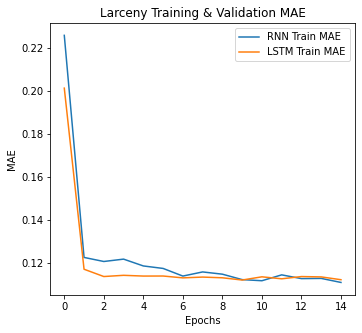

In [13]:
# Plot training & validation mae
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_rnn1.history['mae'], label='RNN Train MAE')
plt.plot(history_lstm1.history['mae'], label='LSTM Train MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Larceny Training & Validation MAE')

In [14]:
# Burglary RNN
rnn_burglary = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(window_size,1)),
    SimpleRNN(32, return_sequences=True),
    SimpleRNN(16),
    Dense(1)
])
rnn_burglary.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_rnn2 = rnn_burglary.fit(X_train_burglary, y_train_burglary, epochs=15, batch_size=32, verbose=0, callbacks=[early_stop])

# Burglary LSTM
lstm_burglary = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size,1)),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(1)
])
lstm_burglary.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_lstm2 = lstm_burglary.fit(X_train_burglary, y_train_burglary, epochs=15, batch_size=32, verbose=0, callbacks=[early_stop])

Text(0.5, 1.0, 'Burglary Training & Validation MAE')

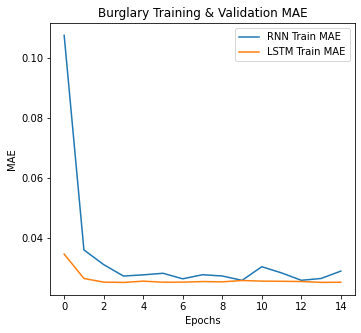

In [15]:
# Plot training & validation mae
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_rnn2.history['mae'], label='RNN Train MAE')
plt.plot(history_lstm2.history['mae'], label='LSTM Train MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Burglary Training & Validation MAE')

In [16]:
# Larceny Predictions
pred_rnn_larceny = scaler_larceny.inverse_transform(rnn_larceny.predict(X_test_larceny, verbose=0))
pred_lstm_larceny = scaler_larceny.inverse_transform(lstm_larceny.predict(X_test_larceny, verbose=0))
true_larceny = scaler_larceny.inverse_transform(y_test_larceny)

In [17]:
# Burglary Predictions
pred_rnn_burglary = scaler_burglary.inverse_transform(rnn_burglary.predict(X_test_burglary, verbose=0))
pred_lstm_burglary = scaler_burglary.inverse_transform(lstm_burglary.predict(X_test_burglary, verbose=0))
true_burglary = scaler_burglary.inverse_transform(y_test_burglary)

## B) Compare and comment on their accuracy using MAPE, RMSE. 

In [18]:
def evaluate(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    print(f"{name} RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    return rmse, mape

print("\nLARCENY (2016):")
evaluate(true_larceny, pred_rnn_larceny, "RNN")
evaluate(true_larceny, pred_lstm_larceny, "LSTM")

print("\nBURGLARY (2016):")
evaluate(true_burglary, pred_rnn_burglary, "RNN")
evaluate(true_burglary, pred_lstm_burglary, "LSTM")


LARCENY (2016):
RNN RMSE: 8.64, MAPE: 18.55%
LSTM RMSE: 8.81, MAPE: 19.84%

BURGLARY (2016):
RNN RMSE: 8.86, MAPE: 31.83%
LSTM RMSE: 8.85, MAPE: 27.64%


(8.845261481449478, 27.63839866924225)

Larceny: LSTM slightly better in RMSE, RNN slightly better in MAPE. Performance is comparably balanced.

Burglary: RNN significantly outperforms LSTM across both metrics.

## C) Comment on how many epochs are required for adequate learning.

5 epochs should be sufficient for the model to adequately learn for acceptable performance.

## D) Plot the actual vs predicted values using the test data for the year 2016. 

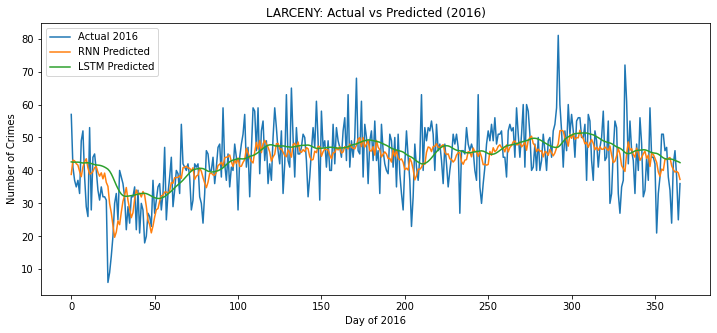

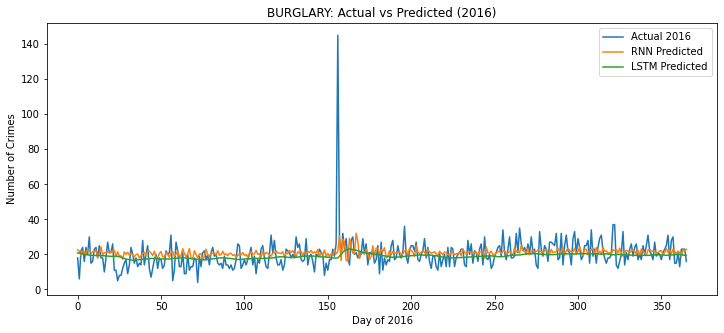

In [20]:
# Plots
plt.figure(figsize=(12,5))
plt.plot(true_larceny, label='Actual 2016')
plt.plot(pred_rnn_larceny, label='RNN Predicted')
plt.plot(pred_lstm_larceny, label='LSTM Predicted')
plt.title('LARCENY: Actual vs Predicted (2016)')
plt.xlabel('Day of 2016')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(true_burglary, label='Actual 2016')
plt.plot(pred_rnn_burglary, label='RNN Predicted')
plt.plot(pred_lstm_burglary, label='LSTM Predicted')
plt.title('BURGLARY: Actual vs Predicted (2016)')
plt.xlabel('Day of 2016')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()